In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
class EWAlg:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0
        self.allPayoffs = []
        self.regret = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return self.myBids[j.item()]
    
    def getRegret(self):
        payoffMatrix = np.array(self.allPayoffs)
        OPT = payoffMatrix.sum(axis=1).max()
        self.regret = OPT - self.myTotalValue
        return self.regret
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        self.weights = self.weights/self.sumWeights
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return
    
    def invertProbabilitesAndGetAction(self):
        invProbs = 1/self.probs
        invProbs = invProbs/np.sum(invProbs)
        j = np.random.choice(self.k, 1, p = invProbs)
        return self.myBids[j.item()]

    def generatePayoffs(self, bidToBeat, meWin, price, myQualiity):
        if meWin:
            self.myTotalValue += self.myValue - price
        payoffs = np.zeros(self.k)
        for count, bid in enumerate(self.myBids):
            if (bid * myQualiity) >= bidToBeat:
                payoffs[count] = self.myValue - bid
            else:
                payoffs[count] = 0
        self.allPayoffs.append(payoffs)
        return payoffs
    
    def reset(self):
        self.weights = np.ones(self.k)
        self.payoffs = np.zeros(self.k)
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myTotalValue = 0


In [23]:
class advertiserTracker:
    def __init__(self, index):
        self.index = index
        self.possibleBids =  np.linspace(0, 1, 100)
        self.possibleValues = np.linspace(0, 1, 100)
        self.actualPayoffs = np.zeros(100)
        self.possiblePayoffs = np.zeros((100, 100))
        self.regrets = []
        self.rounds = 0

    def addPayoffsThisRound(self, bidToBeat, meWin, price, myQualiity):
        for count, value in enumerate(self.possibleValues):
            if meWin:
                self.actualPayoffs[count] += value - price
            thisValPayoffs = np.zeros(100)
            for count2, bid in enumerate(self.possibleBids):
                if (bid * myQualiity) >= bidToBeat:
                    thisValPayoffs[count2] = value - bid
                else:
                    thisValPayoffs[count2] = 0
            self.possiblePayoffs[count] += thisValPayoffs
        self.rounds += 1
        return
    
    def calcRegrets(self):
        regrets = np.zeros(100)
        for count, value in enumerate(self.possibleValues):
            regrets[count] = self.possiblePayoffs[count].max() - self.actualPayoffs[count]
        self.regrets = regrets / self.rounds
        return regrets

Actual Values:
0.2
0.4
0.6
0.51
0.79
Estimated Values:
0.17171717171717174
0.37373737373737376
0.5858585858585859
0.43434343434343436
0.787878787878788


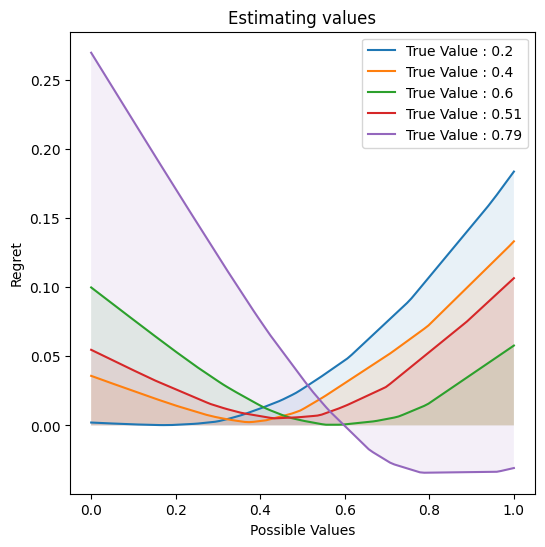

In [37]:
advertisers = []
trackers = []
actualValues = [0.2, 0.4, 0.6, 0.51, 0.79]
print("Actual Values:")
for i in range(5):
    myValue = actualValues[i] # np.random.uniform(0, 1)
    print(myValue)
    actualValues.append(myValue)
    myBids = np.linspace(0, myValue, 100)
    advertisers.append(EWAlg(0.1, 100, 1, myBids, myValue))
    trackers.append(advertiserTracker(i))

for i in range(500):
    bids = []
    qualities = [np.random.uniform(0, 1) for i in range(5)]
    for advertiser in advertisers:
        bids.append(advertiser.getAction())
    qWeightedBids = np.multiply(qualities, bids)
    winningBid = qWeightedBids.max()
    winningBidIndex = qWeightedBids.argmax()
    for count, advertiser in enumerate(advertisers):
        myQuality = qualities[advertisers.index(advertiser)]
        meWin = advertisers.index(advertiser) == winningBidIndex
        payoffs = advertiser.generatePayoffs(winningBid, meWin, bids[winningBidIndex], myQuality)
        advertiser.update(payoffs)
        trackers[count].addPayoffsThisRound(winningBid, meWin, bids[winningBidIndex], myQuality)
    bids.clear()
    qualities.clear()

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)

print("Estimated Values:")
for count, tracker in enumerate(trackers):
    tracker.calcRegrets()
    print(tracker.possibleValues[tracker.regrets.argmin()])
    #for count, epsilon in enumerate(epsilons):
    plt.plot(tracker.possibleValues, tracker.regrets, label = "True Value : " + str(actualValues[count]))
    plt.fill_between(tracker.possibleValues, tracker.regrets, alpha=.1)

plt.title('Estimating values')
plt.xlabel('Possible Values')
plt.ylabel('Regret')
plt.legend()
plt.show()


In [12]:
qualities = [np.random.uniform(0, 1) for i in range(5)]
print(qualities)
bids = [np.random.uniform(0, 1) for i in range(5)]
print(bids)
qWeightedBids = np.multiply(qualities, bids)
print(qWeightedBids)

[0.1687191232123646, 0.506012322613985, 0.7894639833008514, 0.0804294554518743, 0.25779096781933175]
[0.7165368002032316, 0.18083534728871042, 0.9489888322922865, 0.8698479230280217, 0.1138660502329798]
[0.12089346 0.09150491 0.7491925  0.06996139 0.02935364]
